In [3]:
import os, sys

tf_slim_path = os.environ['TF_SLIM_PATH']
tf_slim_path = os.path.abspath(os.path.join(tf_slim_path, 'models/slim', ''))
print tf_slim_path
sys.path.append(tf_slim_path)

/home/ermanoarruda/Libs/tf_slim/models/slim


In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils



# Main slim library
slim = tf.contrib.slim


# Using pre-trained models
### Download the Inception V1 checkpoint

In [5]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = 'checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.



### Apply Pre-trained model to Images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this.

In [6]:
import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim

batch_size = 3
image_size = inception.inception_v1.default_image_size

Image shape: (224, 224, 3)


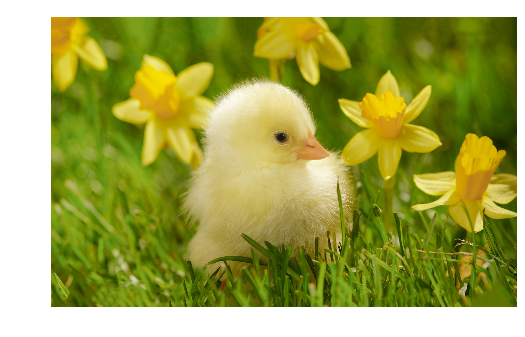

Probability 0.10% => [hen]
Probability 0.08% => [albatross, mollymawk]
Probability 0.07% => [bald eagle, American eagle, Haliaeetus leucocephalus]
Probability 0.03% => [goose]
Probability 0.03% => [weasel]


In [7]:
conv_features_0 = None
with tf.Graph().as_default():
    url = 'http://baby-animals.net/wp-content/gallery/Baby-chicken-wallpapers/little-chick-wallpaper.jpg'#'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    print "Image shape:", processed_image.get_shape()
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, end_points = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    conv_layer_0 = end_points['Conv2d_1a_7x7']
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities, conv_features_0 = sess.run([image, probabilities,conv_layer_0])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index], names[index]))

(112, 112)


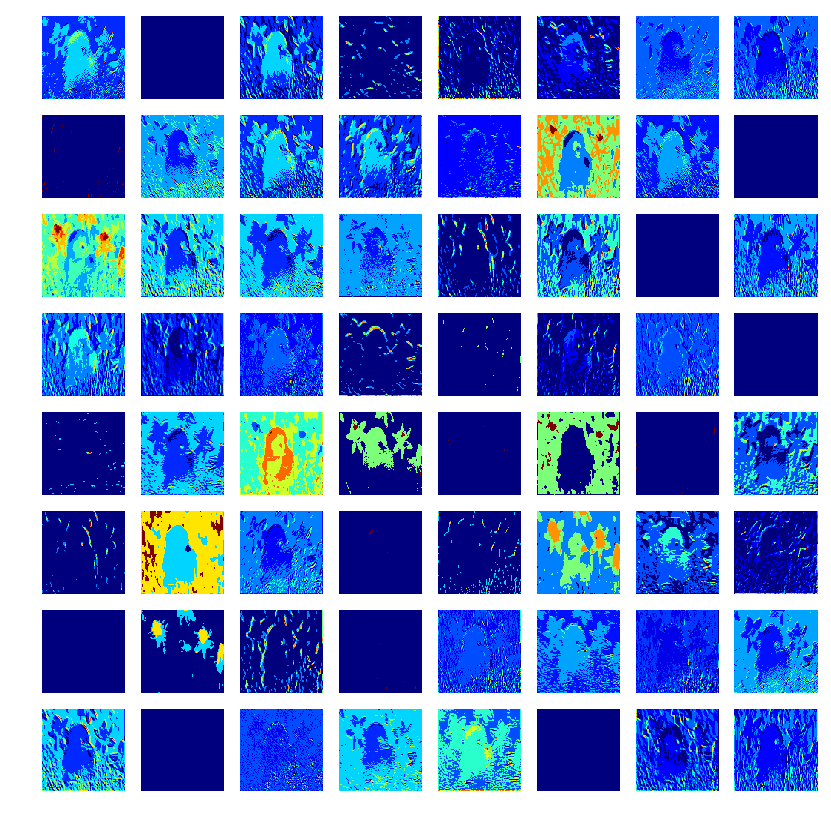

In [8]:
print conv_features_0[0,:,:,1].shape



fig1 = plt.figure(figsize = (10,10))



for i in range(0,64):
    ax1 = fig1.add_subplot(8,8,i+1) 
    ax1.imshow(conv_features_0[0,:,:,i].astype(np.uint8), interpolation='nearest')
    ax1.axis('off')
    
plt.show()

## Loading inception model

In [3]:
import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim

batch_size = 1
image_size = inception.inception_v1.default_image_size

## Helper functions

In [34]:
def init_weights(shape, name=None):
    return tf.get_variable(name, initializer=tf.random_normal(shape, stddev=0.01))

def init_bias(shape, name=None):
    return tf.get_variable(name, initializer=tf.zeros(shape, dtype='float'))

def conv2d(img, w, b, strides=[1, 1, 1, 1]):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=strides, padding='SAME'), b))

def load_inception_model():
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        
        net_input = tf.placeholder("float", [None, image_size, image_size, 3], name='nn_input')
        
        logits, end_points = inception.inception_v1(net_input, num_classes=1001, is_training=False)
        
        init_fn = slim.assign_from_checkpoint_fn(
        os.path.join('./checkpoints', 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
        
        return logits, end_points, init_fn, net_input
    

def get_fp_layer(conv_layer_in):
    _, num_rows, num_cols, num_fp = conv_layer_in.get_shape()
    num_rows, num_cols, num_fp = [int(x) for x in [num_rows, num_cols, num_fp]]
    x_map = np.empty([num_rows, num_cols], np.float32)
    y_map = np.empty([num_rows, num_cols], np.float32)

    for i in range(num_rows):
        for j in range(num_cols):
            x_map[i, j] = (i - num_rows / 2.0) / num_rows
            y_map[i, j] = (j - num_cols / 2.0) / num_cols

    x_map = tf.convert_to_tensor(x_map)
    y_map = tf.convert_to_tensor(y_map)

    x_map = tf.reshape(x_map, [num_rows * num_cols])
    y_map = tf.reshape(y_map, [num_rows * num_cols])

    # rearrange features to be [batch_size, num_fp, num_rows, num_cols]
    features = tf.reshape(tf.transpose(conv_layer_in, [0,3,1,2]),
                          [-1, num_rows*num_cols])
    softmax = tf.nn.softmax(features)

    fp_x = tf.reduce_sum(tf.mul(x_map, softmax), [1], keep_dims=True)
    fp_y = tf.reduce_sum(tf.mul(y_map, softmax), [1], keep_dims=True)

    fp = tf.reshape(tf.concat(1, [fp_x, fp_y]), [-1, num_fp*2])
    
    return fp

def get_mlp_layers(mlp_input, number_layers, dimension_hidden):
    """compute MLP with specified number of layers.
        math: sigma(Wx + b)
        for each layer, where sigma is by default relu"""
    cur_top = mlp_input
    weights = []
    biases = []
    
    for layer_step in range(0, number_layers):
        in_shape = cur_top.get_shape().dims[1].value
        cur_weight = init_weights([in_shape, dimension_hidden[layer_step]], name='w_' + str(layer_step))
        cur_bias = init_bias([dimension_hidden[layer_step]], name='b_' + str(layer_step))
        weights.append(cur_weight)
        biases.append(cur_bias)
        if layer_step != number_layers-1:  # final layer has no RELU
            cur_top = tf.nn.relu(tf.matmul(cur_top, cur_weight) + cur_bias)
        else:
            cur_top = tf.matmul(cur_top, cur_weight) + cur_bias

    return cur_top, weights, biases

def get_conv_weights(key_w = 'wc2',key_b = 'bc2', filter_size = 5, input_channels = 64, output_channels = 64):
    with tf.variable_scope('conv_params'):
        weights = {
            key_w: init_weights([filter_size, filter_size, input_channels, output_channels], name=key_w), # 5x5 conv, 32 inputs, 64 outputs        
        }

        biases = {
            key_b: init_bias([output_channels], name=key_b),
        }
        
    
    
        return weights, biases
    
def euclidean_loss(a, b, batch_size):
    scale_factor = tf.constant(2*batch_size, dtype='float')
    squared_diff = tf.square(a-b)

    cost = tf.reduce_sum(squared_diff)

    return cost/scale_factor

np.random.seed(seed=42)

def fakeImageInput():
    image = np.random.randn(299,299,3)
    image = np.transpose(image,(2,1,0)) # If the image is WxHxC, make it CxWxH
    image = image.flatten()

    return image


In [46]:
dim_output = 9
n_layers = 3
layer_size = 20
dim_hidden = (n_layers - 1)*[layer_size]
dim_hidden.append(dim_output)
filter_size = 5

p0 = np.array([0,0,0])
p1 = np.array([0,1,0])
p2 = np.array([0,1,1])
points = np.concatenate((p0,p1,p2))

image_input = None
probabilities = None
image = None
processed_images = None
init_op = None
train_op = None
position = None
features_op = None
np_image = None

url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
image_string = urllib2.urlopen(url).read()

my_graph = tf.Graph()

with my_graph.as_default(): 
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    logits, end_points, init_fn, image_input = load_inception_model()
    probabilities = tf.nn.softmax(logits)
    
    conv_layer_0 = end_points['Conv2d_1a_7x7']
            
        
    weights, biases = get_conv_weights('wc2','bc2',5,64,32)
    conv_layer_1 = conv2d(img=conv_layer_0, w=weights['wc2'], b=biases['bc2'])
    
    weights2, biases2 = get_conv_weights('wc3','bc3',5,32,3)
    conv_layer_2 = conv2d(img=conv_layer_1, w=weights2['wc3'], b=biases2['bc3'])
            
    features_op = get_fp_layer(conv_layer_2)
    
    fc_output, _, _ = get_mlp_layers(features_op, n_layers, dim_hidden)
    
    position = tf.placeholder('float', [None, dim_output], name='position')
    
    loss_op = euclidean_loss(a=position, b=fc_output, batch_size=25)
    
    train_op = tf.train.AdamOptimizer(1e-4).minimize(loss_op)
    
    init_op = tf.initialize_all_variables()
    

# Reseting graph
# tf.reset_default_graph()

Probability 0.45% => [cocker spaniel, English cocker spaniel, cocker]
Probability 0.23% => [Sussex spaniel]
Probability 0.10% => [Irish setter, red setter]
Probability 0.04% => [Welsh springer spaniel]
Probability 0.03% => [clumber, clumber spaniel]


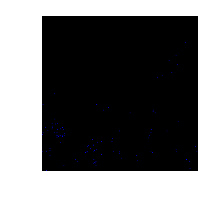

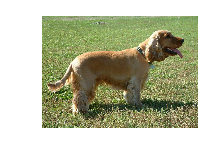

In [47]:
with tf.Session(graph = my_graph) as sess:
    
    sess.run(init_op)
        
    init_fn(sess)
        
        
    processed_images_input = sess.run([processed_images])[0]
    np_image, np_processed_img, probabilities = sess.run([image, processed_image,probabilities], feed_dict={image_input: processed_images_input})

        
    probabilities = probabilities[0, 0:]
    sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure(figsize = (2,2))
    plt.imshow(np_processed_img.astype(np.uint8))
    plt.axis('off')
        
    plt.figure(figsize = (2,2))
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
        
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index], names[index]))            

In [37]:

features = None
with tf.Session(graph = my_graph) as sess:
    sess.run(init_op)
    init_fn(sess)
    for iteration in range(200):
        loss = sess.run([loss_op,train_op],feed_dict={image_input: processed_images_input,
                                                             position: np.expand_dims(points,axis=0)
                                            })
        # print every 50 iters
        if iteration%100 == 0:
            print "iteration %d loss: "%(iteration), loss

iteration 0 loss:  [0.059999991, None]
iteration 100 loss:  [0.058397155, None]
iteration 200 loss:  [0.053815473, None]
iteration 300 loss:  [0.044602942, None]
iteration 400 loss:  [0.031085389, None]
iteration 500 loss:  [0.016624734, None]
iteration 600 loss:  [0.0060216212, None]
iteration 700 loss:  [0.0012939933, None]
iteration 800 loss:  [0.00015765773, None]
iteration 900 loss:  [1.193139e-05, None]


In [42]:

features = None
with tf.Session(graph = my_graph) as sess:
    sess.run(init_op)
    init_fn(sess)

    features, np_image = sess.run([features_op, image],feed_dict={image_input: processed_images_input
                                            })
    features = features[0]



## Plotting helpers

In [43]:
import cv2

def draw_features(features,image_data):
    
    try:
        (rows,cols,channels) = image_data.shape
        i_feat = 0
        while i_feat < len(features):
            cx = cols/2 + int(float(features[i_feat]*cols)/2)
            cy = rows/2 + int(float(features[i_feat+1]*rows)/2)
            cv2.circle(image_data, (cx,cy), 10, 255)
            i_feat += 2
    except Exception as e:
        print(e)

    return image_data

def show_image(image):

    cv2.imshow("RGB Image window", image)

    cv2.waitKey(1)



In [44]:
print features
img = draw_features(features,np_image)

[ 0.00056066 -0.00390353 -0.00417621 -0.00454529 -0.00303478 -0.00521523]


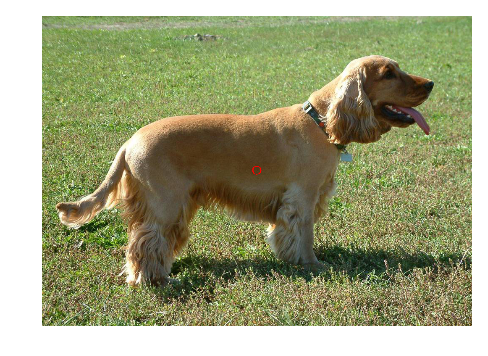

In [45]:

plt.axis("off")
plt.imshow(img)
plt.show()
#np.expand_dims(prepared_obs[i],0)